I'll load the first created model in the `model_creation` notebook, since it achieved the highest score during evaluation. I'll use the model to make some predictions and visualize the items' embeddings in a 2D space using PCA.

For each plotted movie vector representation, I'll also display its genres list. This will enable us to check if there are any similarities between genres of predicted movies.

In [1]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from adjustText import adjust_text

pd.set_option('display.max_colwidth', -1)


In [3]:
movies = pd.read_csv('./../data/raw/movies.dat', sep="::", usecols=[0, 1, 2], names=['movieId', 'title', 'genres'],
                         engine='python')
movies['movieId'] = movies['movieId'].astype(str)


id_to_title = pd.Series(movies['title'].values,
                        index=movies['movieId'].values).to_dict()

model = Word2Vec.load('./../models/model_2')


In [4]:
def get_genres_for_movie_title(movie_title):
    movie_by_title = movies[movies['title'] == movie_title]
    return movie_by_title.iloc[0]['genres'] if len(movie_by_title) > 0 else ""

In [23]:
def get_random_items_with_predicted_similars(model, noOfItems):
    vocab = list(model.wv.vocab.keys())
    output = list()
    items_with_predictions = []

    for i in range(0, noOfItems):
        index = np.random.randint(len(vocab), size=1)[0]
        suggestions = model.wv.most_similar(positive=[vocab[index]], topn=5)
        suggest = list()
        
        for suggestion in suggestions:
            suggest.append(suggestion[0])
        items_with_predictions.append([vocab[index], suggest])
        
    return items_with_predictions
    
def plot_with_labels(low_dim_embs, labels):
    plt.figure(figsize=(20, 16))
    texts = []
    x_list = []
    y_list = []

    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        
        texts.append(plt.text(x, y, label ))
        x_list.append(x)
        y_list.append(y)
        
    plt.plot(x_list, y_list, 'bo')
        
    # adjust plot labels so they won't overlap
    adjust_text(texts)
    plt.savefig("./../visualization_outputs/pca_movies_representations.png")


def plot_vocab_representation(model, id_to_title, noOfItems):
    vocab = model.wv.vocab.keys()

    # reduce vector embeddings size to 2D in order to plot them 
    pca = PCA(n_components=2)
    pca.fit(model.wv.vectors)

    embeds = []
    labels = []
    
    item_similarities = {'Movie':[], 'Top 5 most similar movies': []}

    for item, predictions in get_random_items_with_predicted_similars(model, noOfItems):
        prediction_titles = [id_to_title[pred] for pred in predictions]
        if not (type(id_to_title[item]) == float and np.isnan(id_to_title[item])):
            title_and_genres = "{} ({})".format(id_to_title[item], get_genres_for_movie_title(id_to_title[item]))
            item_similarities['Movie'].append(title_and_genres)
            prediction_titles = ["{} ({})".format(x, get_genres_for_movie_title(x)) for x in prediction_titles]
            item_similarities['Top 5 most similar movies'].append(prediction_titles)
                
        all_items = [item] + predictions
        
        for x in all_items:
            embeds.append(model.wv[x])
            labels.append("{} ({})".format(id_to_title[x], get_genres_for_movie_title(id_to_title[x])))
        
    embeds = np.array(embeds)
    embeds = pca.fit_transform(embeds)
    
    df = pd.DataFrame.from_dict(item_similarities)
    print(df)
    plot_with_labels(embeds, labels)

                                      Movie  \
0  Cape Fear (1962) (Film-Noir|Thriller)      
1  Big Hit, The (1998) (Action|Comedy)        
2  Get on the Bus (1996) (Drama)              
3  Murphy's Romance (1985) (Comedy|Romance)   
4  Hilary and Jackie (1998) (Drama)           

                                                                                                                                                                                                   Top 5 most similar movies  
0  [Key Largo (1948) (Crime|Drama|Film-Noir|Thriller), Three Days of the Condor (1975) (Thriller), 39 Steps, The (1935) (Thriller), Double Indemnity (1944) (Crime|Film-Noir), Spellbound (1945) (Mystery|Romance|Thriller)]  
1  [Replacement Killers, The (1998) (Action|Thriller), Beverly Hills Ninja (1997) (Action|Comedy), Metro (1997) (Action), Desperado (1995) (Action|Romance|Thriller), Bad Boys (1995) (Action)]                               
2  [American Buffalo (1996) (Drama), He Got Game

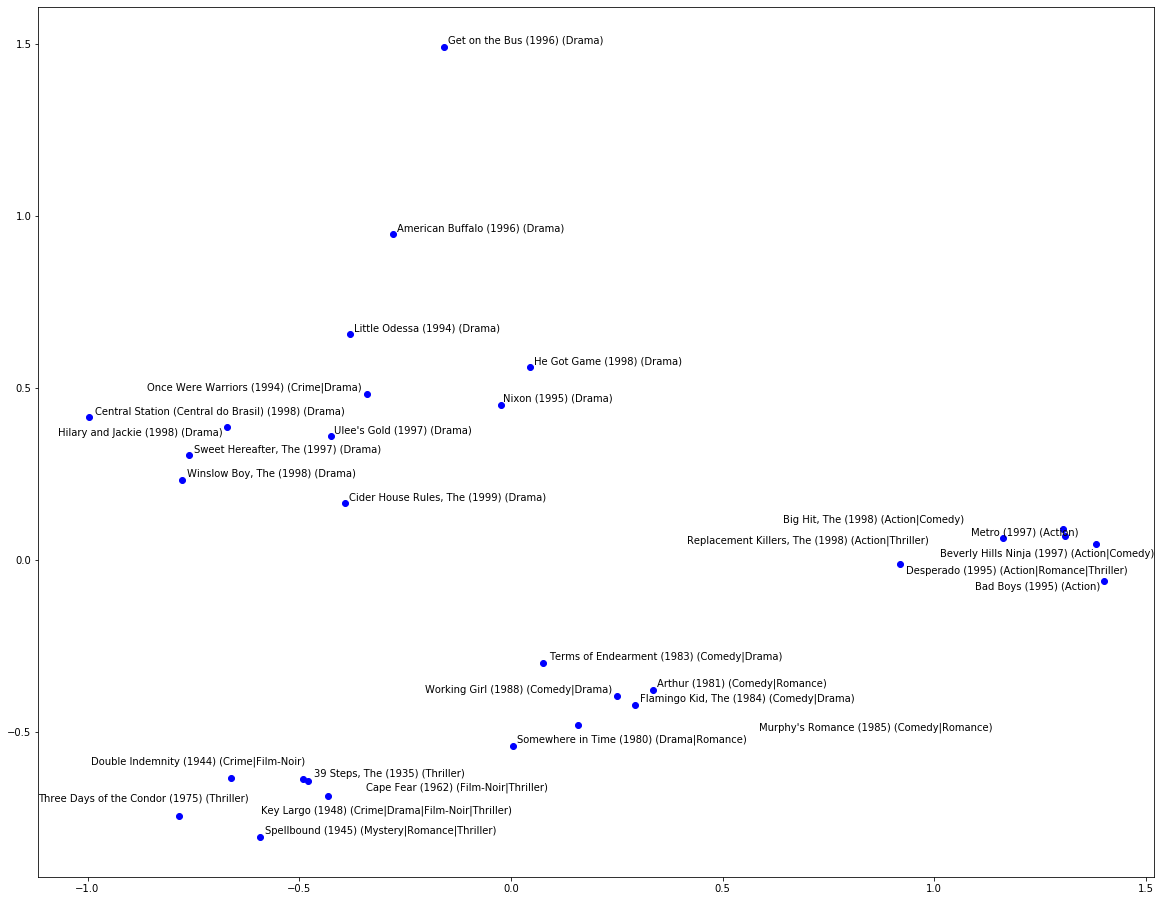

In [30]:
plot_vocab_representation(model, id_to_title, noOfItems=5)

I picked 5 random movies and for each movie I predicted the most similar 5 movies using the trained Word2Vec model.

After that, I extracted their vector embeddings and used PCA to obtain a 2D representation for each embedding. Doing this I was able to offer a visual representation for each movie. One can notice that movies with similar genres tend to be close to one another. There are some clusters that stand out:
- Thriller/Film-Noir movies at the bottom-left corner
- Action movies in the middle-right
- Comedy/Drama movies in bottom-half of the plan
- Drama movies in the top-left

There are more Drama movies depicted in this example because 2/5 randomly picked movies were associated with this genre.
These visual results confirm that the model was able to learn meaningful movie embeddings.